<a href="https://colab.research.google.com/github/Sbastdia/-lgebra-lineal-num-rica/blob/master/La%20_ecuacion%20_de_conveccion_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## La ecuacion de conveccion 1D


Vamos a ver nuestro primer ejemplo de ecuación diferencial: la ecuación de convección 1D.

$$
\phi_t + u \phi_x = 0
$$

En este caso, la variable conservativa es $\phi(x, t)$ y el flujo es $f(\phi(x,t)) = u \phi(x, t)$ donde $u$ es la velocidad, un valor escalar constante. Esta ecuación es muy útil por varios motivos. En primer lugar, considerando condiciones de contorno periódicas, tiene solución analítica

$$
\phi(x,t) = \phi_0(x - ut)
$$

donde $\phi_0$ es la condición inicial. A grandes rasgos, la condición inicial se propagará en $x$ a la velocidad $u$. Esto convierte a la ecuación de convección 1D como un perfecto benchmark para probar diferentes métodos numéricos.

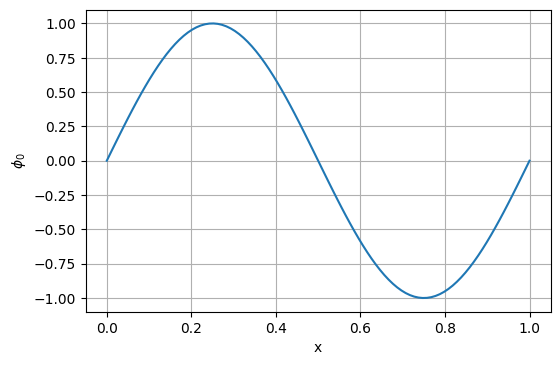

In [ ]:
# LIBRERÍAS:
# Numpy es una librería que nos permite trabajar de manera sencilla con vectores y matrices
# NOTA: Mas adelante usaremos Pytorch, que es mas completo que numpy. Pasar de una libreria a otra es sencillo, cambia la notación.
import numpy as np

# Librería muy popular para realizar calculos matemáticos
import math

# Librería para visualizar el contenido en gráficas
import matplotlib.pyplot as plt



# GRAFICA
# Devuelve un arreglo de números equiespaciados dentro del intervalo [0, 1] con un total de 100 elementos.
x = np.linspace(0,1,100)

# Funcion seno de 2 * pi * x
p = np.sin(2*math.pi*x)

# Tamaño de la grafica
plt.figure(dpi=100)

# Lo que queremos dibujar
plt.plot(x, p)

# Dibuja una malla sobre el gráfico
plt.grid(True)

# Etiquetas de la gráfica
plt.xlabel('x')
plt.ylabel('$\phi_0$')

# Mostrar la gráfica
plt.show()

In [ ]:
# LIBRERIAS
# Para animar nuestra grafica
from matplotlib import animation, rc
rc('animation', html='html5')

# GRÁFICA
def update(i):
    '''Actualizamos el gráfico en cada paso de la animación'''
    # Borramos los elementos del gráfico anterior
    ax.clear()

    # Empezamos el nuevo
    ax.plot(x, ps[i], "b")
    ax.set_xlabel('x')
    ax.set_ylabel('$\phi$')
    ax.set_title(f't = {ts[i]:.3f}')
    ax.grid(True)
    return ax

def compute_sol(x, u, t):
    '''Resuelve nuestra ecuación'''
    return np.sin(2*math.pi*(x - u*t))


# u es la velocidad que multiplica como una constante al termino convectivo
# NOTA: Cuanto mayor sea la u, mayor será la velocidad
u = 2

# Partimos 1 segundo en 50 intervalos para plotearlo de manera discreta
# NOTA: Cuanto más dividamos el tiempo, mayor sensación de continuidad dará
ts = np.linspace(0,1,50)

# Aquí vamos a guardar cada una de las 50 gráficas
ps = []

# Generamos un bucle for para almacenar en ps cada uno de los 50 estados
for t in ts:
    p = compute_sol(x, u, t)
    ps.append(p)


fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)

# Esta función se encarga de crear la animación.
# Toma como entrada el gráfico fig, la función update que se utilizará para actualizar el gráfico en cada paso de la animación, el número de pasos de la animación (determinado por el número de elementos en la lista ps) y el intervalo entre pasos en milisegundos (en este caso 200 milisegundos).
# La animación se almacena en la variable anim
anim = animation.FuncAnimation(fig, update, frames=len(ps), interval=200)
plt.close()

# Ahora vamos a ver como la función sinusoidal se desplaza a la derecha con velocidad u
# NOTA: Cuando t vale 0 tenemos la función del seno
anim



RuntimeError: Requested MovieWriter (ffmpeg) not available

###Resolucion de volumenes finitos



Lo primero que necesitamos para resolver la ecuación es discretizar nuestro dominio en un conjunto de celdas.

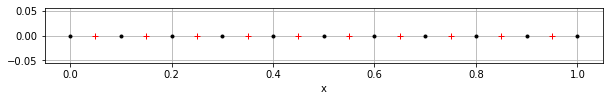

In [ ]:
# Vamos a discretizar el dominio
# L es la longitud del dominio
# N es el numero de puntos en el dominio
# u es la velocidad del flujo
L, N, u = 1., 10, 1.
dx, dt = L / N, (L / N) / u

f = np.linspace(0,L,N+1) # caras
c = np.linspace(0.5*dx,L-0.5*dx,N) # celdas

plt.figure(figsize=(10,1))

# Cara de cada uno de los volúmenes
plt.plot(f, np.zeros(N+1), '.k')

# Centroide de cada uno de los volúmenes
plt.plot(c, np.zeros(N), '+r')


# Graficamos para ver su equidistancia en una dimensión antes de aplicarle nuestra función seno
plt.grid(True)
plt.xlabel('x')
plt.show()

Ahora, nuestra condición inicial estará definida en cada celda como el valor en su centroide.

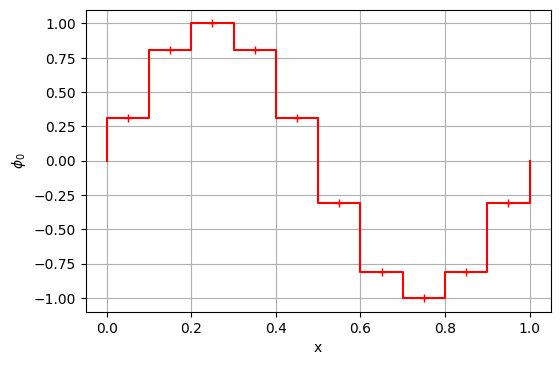

In [ ]:
# Aplicamos nuestra función seno para ver donde caen cada uno de nuestros centroides descritos en `c`
p0 = np.sin(2*math.pi*c)

# Graficamos los centroides
plt.figure(dpi=100)
plt.plot(c, p0, '+r')

# `a` y `b` representan los volúmenes asumiendo que la solucion es constante en cada uno de los mismos
# `a` corresponde al eje de las x
# `b` corresponde al eje de las `phi_0`
a, b = [0], [0]

# Asignamos a cada centroide un escalón (lo que hemos pasado por nuestra función)
# Este lo tenemos que dividir en tres partes donde el centroide lógicamente le corresponde la del medio
# Y las otras dos se corresponden con la mitad de lo que equidista cada punto
for i in range(N):
    a += [c[i] - 0.5*dx, c[i], c[i] + 0.5*dx]
    b += [p0[i], p0[i], p0[i]]
a += [1]
b += [0]

# Graficamos nuestra función discretizada
plt.plot(a, b, '-r')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$\phi_0$')
plt.show()

Como hemos visto antes, para calcular la evolución temporal de la variable conservativa necesitamos calcular su flujo a través de sus caras. Un par de esquemas simples son los conocidos como *upwind* (UDS), que usa el valor aguas arriba, y *central* (CDS) que usa el valor medio entre los valores a cada lado de la cara.

In [ ]:
import numpy as np


def compute_flux(p, u, scheme='uds'):
    '''Aplicamos un método a cada uno de los centroides siendo uds el que viene por defecto'''

    # N es el tamaño de la lista "p0"
    N = len(p)

    # Generamos una lista de 1 de tamaño N, aquí es donde vamos a almacenar los resultados
    f = np.ones(N+1)

    # l y r corresponden a los indices donde l siempre va a ser el anterior
    for i in range(N+1):
        l, r = i-1, i
        if i == 0:
            l = N - 1
        elif i == N:
            r = 0

        # A este método se le conoce como aguas arriba
        if scheme == 'uds':
            # Sacamos el valor de la derecha de cada centroide
            f[i] = p[l] if u > 0 else p[r]

        # A este método se le conoce como  esquema tipo centrado
        elif scheme == 'cds':
            # Sacamos la mitad de cada escalón
            f[i] = 0.5*(p[l] + p[r])
        else:
            # Lanzamos excepción en caso de no haber introducido uno de estos dos métodos
            raise 'invalid scheme'
    return f

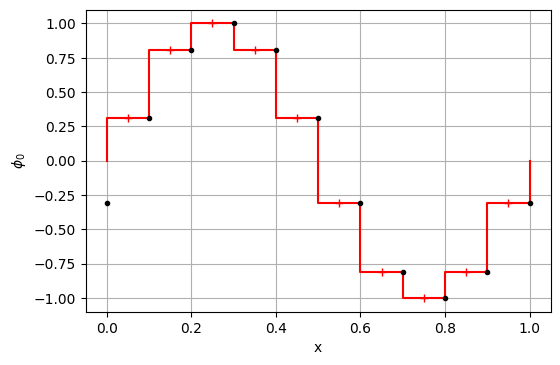

In [ ]:
# Sabemos que si la velocidad es positiva, esta onda se está moviendo hacia la derecha
# Por ello asumimos que el valor de cada una de las caras le corresponde al centroide de su izquierda
pf = compute_flux(p0, u, 'uds')

# Graficamos
plt.figure(dpi=100)
plt.plot(c, p0, '+r')
plt.plot(a, b, '-r')

# Mostramos en negro el resultado del esquema
plt.plot(f, pf, '.k')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$\phi_0$')
plt.show()

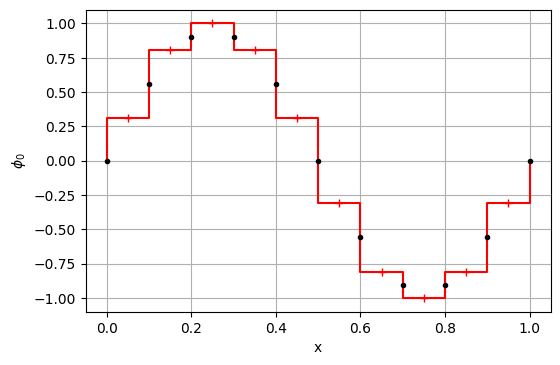

In [ ]:
# Otra alternativa al esquema upwind
# Como sabemos el valor de cada lado de la cara, calculamos el valor medio de cada escalón
pf = compute_flux(p0, u, 'cds')

# Graficamos
plt.figure(dpi=100)
plt.plot(c, p0, '+r')
plt.plot(a, b, '-r')

# Mostramos en negro el resultado del esquema
plt.plot(f, pf, '.k')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$\phi_0$')
plt.show()

Para cada celda, calcularemos la variación de la magnitud conservativa como la cantidad que sale por la cara de la derecha menos la que entra por la cara izquierda (teniendo en cuenta el signo).

In [ ]:
def sum_fluxes(pf):
	'''Variación de la magnitud'''
	# N es el tamaño de la lista "p1" - 1
	# Esto l hacemos para posteriormente no salirnos del rango de la lista
	N = len(pf) - 1

	# Creamos provisionalmente r como una lista de ceros de tamaño N
	r = np.zeros(N)

	# Restamos a cada valor de pf el posterior
	for i in range(N):
		r[i] = pf[i] - pf[i+1]
	return r

Por último, podemos actualizar el resultado usando un esquema de integración temporal, en este caso aplicamos un esquema sencillo de primer orden.

$$
    \frac{\partial \phi}{\partial t} \approx \frac{\phi^{n+1} - \phi^n}{t^{n+1} - t^{n}}
$$

In [ ]:
def update_p(p0, r, dt, dx):
	# N es el tamaño de la lista "p0"
	N = len(p0)

	# Declaramos lista o vector de ceros al igual que antes
	p = np.zeros(N)

	# Actualizamos el resultado
	for i in range(N):
		p[i] = p0[i] + (dt/dx)*r[i]
	return p

In [ ]:
# Juntamos todos los pasos:

# Aplicamos la función seno a todos los centroides
p0 = np.sin(2*math.pi*c)

# Pasamos todos los puntos por el método upwind
pf = compute_flux(p0, u)

# Tomamos también el punto mas negativo de cada escalón
r = sum_fluxes(pf)
p = update_p(p0, r, dt, dx)

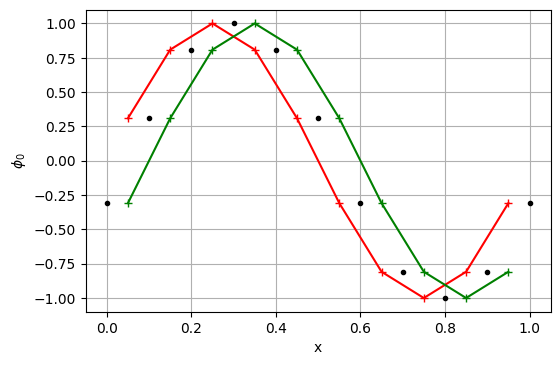

In [ ]:
# Graficando vemos como los centroides nos quedan en el medio de color negro
plt.figure(dpi=100)
plt.plot(c, p0, '+-r')
plt.plot(f, pf, '.k')
plt.plot(c, p, '+-g')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$\phi_0$')
plt.show()

In [ ]:
# Desplazamos los centroides 0.1 (nuestra equidistancia) a la derecha y volvemos a realizar el mismo paso
pf = compute_flux(p, u)
r = sum_fluxes(pf)
p1 = update_p(p, r, dt, dx)

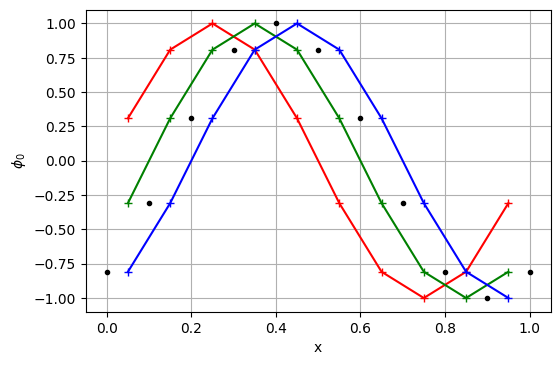

In [ ]:
# Comprobamos como hemos desplazado la gráfica a la derecha pudiendo hacer esto indefinidamente en ambas direcciones
# Unicamente tendríamos que aplicar nuevamente la función n veces para representar el movimiento en el tiempo
plt.figure(dpi=100)
plt.plot(c, p0, '+-r')
plt.plot(f, pf, '.k')
plt.plot(c, p, '+-g')
plt.plot(c, p1, '+-b')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$\phi_0$')
plt.show()

In [ ]:
def run_sim(cfl = 1., scheme='uds'):
    '''Esta función nos deveulve tres listas que representan como cambia la ecuación respecto al tiempo'''

    # Condición inicial
    p0 = np.sin(2*math.pi*c)

    # En ps vamos a añadir nuestras soluciones de forma numérica
    ps = [p0]

    # En pa añadimos nuestras soluciones analíticas
    pa = [p0]

    # En ts almacenamos los diferenciales de tiempo, es decir, la tasa de cambio respecto al tiempo.
    # Este diferencial se mantiene constante a lo largo de la ecuación.
    ts = [0]

    # Lógicamente partimos de tiempo 0
    t = 0

    # Calculamos el diferencial del tiempo, al igual que hemos hecho antes
    # Con la diferencia de que ahora le vamos a multiplicar la Condición de estabilidad de Courant-Friedrichs-Lewy
    dt = cfl * (L / N) / u

    # Representamos el resultado al cabo de 1 segundo de tiempo aunque perfectamente podríamos aumentarlo cambiando este dato
    # NOTA: Tomamos 1 para ver como cambia en un periodo
    while t + dt < 1.:
        # Rellenamos las tres listas
        t += dt
        pf = compute_flux(p0, u, scheme)
        r = sum_fluxes(pf)
        p = update_p(p0, r, dt, dx)
        ps.append(p)
        pa.append(compute_sol(c, u, t))
        ts.append(t)
        p0 = p.copy()
    return ps, pa, ts

In [ ]:
def update(i):
    '''Similar a nuestro update anterior'''
    ax.clear()

    # Dibujamos nuestra solución analítica en azul
    ax.plot(c, pa[i], "-b")

    # Dibujamos la solución numérica en rojo
    ax.plot(c, ps[i], "+-r")
    ax.set_xlabel('x')
    ax.set_ylabel('$\phi$')
    ax.set_title(f't = {ts[i]:.3f}')
    ax.grid(True)
    ax.set_ylim(-1.1,1.1)
    return ax

In [ ]:
# Animamos nuestra ecuación original, resuelta de forma numérica.
# Tomamos el cfl como 1 por defecto
ps, pa, ts = run_sim()

fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(ps), interval=200)
plt.close()

anim

En este caso particular, resolver la ecuación de convección con un esquema UDS en una malla regular con un incremento temporal $dt = \frac{dx}{u}$ y velocidad constante es equivalente a la solución analítica. Esto es debido a que, bajo estas condiciones especiales, el flujo calculado es exacto. Esto, sin embargo, nunca será el caso ya que trabajaremos con mallas irregulares, la velocidad del fluido será variables, etc. En estos casos, el uso de un esquema UDS resulta en una solución artificalmente viscosa.

In [ ]:
# Encima de nuestra ecuación original, animamos el esquema de tipo upwind que hemos realizado anteriormente
ps, pa, ts = run_sim(cfl=0.5)

# Vamos a observar como la solución numérica se va achatando por las propiedades del método upwind
# Existen otros métodos para hacer que no sea tan exagerado, para solucionar este problema
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(ps), interval=200)
plt.close()

anim

El esquema CDS, por otro lado, acumulará errores debido a la aproximación que resultan en la divergencia de la simulación.

In [ ]:
# Ahora vamos a realizar la comparación con el esquema centrado
ps, pa, ts = run_sim(cfl=.5, scheme="cds")

# Esta vez vemos el caso contrario, de como la solución numérica se va alargando.
# En este caso por la acumulación de errores, al cabo del tiempo esta solución diverge
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(ps), interval=200)
plt.close()

anim

Para aliviar estos problemas se suele recurrir a esquemas numéricos de alto nivel (como por ejemplo los esquemas Runge Kutta para la integración temporal), el uso de mallas muy densas y saltos temporales muy pequeños con el objetivo de reducir al mínimo los errores de aproximación. Este es el principal motivo por el que resolver ecuaciones diferenciales con métodos numéricos suele requerir de grandes requisitos computacionales. La pregunta ahora es: ¿podemos mejorar esto con redes neuronales? La respuesta es ¡SÍ! 

## PINNs

 Vamos a empezar introduciendo el uso de *PINNs*, o *Physics informed Neural Networks*. En este caso, usaremos redes neuronales para aproximar la solución a ecuaciones diferenciales usando la misma ecuación como objetivo de aprendizaje (función de pérdida). Así pues, nuestra red neuronal recibirá a la entrada un conjunto de valores de las variables independientes, en nuestro ejemplo $x$ y $t$, y nos dará a la salida el valor de la variable conservativa, $\phi$ (la cual deberá satisfacer la ecuación diferencial).

In [ ]:
# LIBRERÍAS
# torch es una librería de cálculo científico que proporciona soporte para el cálculo con tensores.
# Nos ayuda también con el entrenamiento de redes neuronales
import torch

# Este módulo proporciona un conjunto de capas de red neuronal, utilizados para el aprendizaje profundo (deep learning)
import torch.nn as nn


# FUNCIÓN DE ACTIVACIÓN
# Vamos a usar `sin` como función de activación.
# Funciona mucho mejor que RELU u otras alternativas, se puede ver en diferentes papers enfocados a este tipo de aplicaciones.
# En resumen, hace que el algoritmo converja mas rápido

class Sine(nn.Module):
		'''Esta clase sera utilizada como función de activación'''
		def __init__(self):
				# Heredamos el constructo del modulo mediante super
				super().__init__()
		def forward(self, x):
				# Este método se llamará cuando se utilice la capa en un modelo de red neuronal y realizará el cálculo de "sin" en el tensor de entrada "x"
				return torch.sin(x) #Elegimos el "sin(x)" porque debido a su propiedad de convergencia, esta converge más rápido que otras funciones


# DECLARACIÓN DE LA RED
# Perceptrón multicapa con dos entradas(x,t) y una sola salida (phi)
# En esta caso nuestra red neuronal secuencial dispone de:
# 	- Dos entradas
# 	- Dos capas ocultas: Con 100 unidades cada una
# 	- Una capa de salida: Con una sola unidad
mlp = nn.Sequential(
	nn.Linear(2, 100),
	Sine(),
	nn.Linear(100, 100),
	Sine(),
	nn.Linear(100, 1)
)


Para hacer el entrenamiento de esta red, no vamos a hacerlo de la forma tradicional, usando muchas soluciones provenientes de datos generados por nosotros a los cuales aplicaremos un método supervisado o no supervisado, sino que vamos a hacer que nuestra red sea una solución buena a esta ecuación diferencial con unas propiedades interesantes.

In [ ]:
# ENTRENAMIENTO DE LA RED


# Cantidad de pasos de optimización que vamos a utilizar, no confundir con las Epoachs habitualmente usadas
# Podemos ir controlando este hiperparametro para ir mejorando el aprendizaje
N_STEPS = 5000

# Con N_SAMPLES y N_SAMPLES_O controlamos el tamaño de los conjuntos de datos que se utilizan para entrenar la red
# "N_SAMPLES" se utiliza para generar un conjunto de pares de entrada (x, t) que se utilizan para calcular la función de pérdida "pde_loss" y para optimizar la red para cumplir con la ecuación diferencial parcial.
N_SAMPLES = 200
# "N_SAMPLES_0" se utiliza para generar dos conjuntos de entrada (x, 0) y (1, t), que se utilizan para calcular la función de pérdida "ini_loss" y "bound_loss", respectivamente. Estos conjuntos de entrada se utilizan para optimizar la red para cumplir con la condición inicial y las condiciones de contorno, respectivamente.
N_SAMPLES_0 = 100

# Optimizador
# Este es el algoritmo que se utiliza para actualizar los pesos de la red durante el entrenamiento.
# Su objetivo es minimizar la función de pérdida de la red
# En este caso utilizamos Adam, que es un optimizador adaptativo basado en el algoritmo de gradiente descendiente estocástico para mejorar la convergencia
# Le pasamos como argumento los parámetros de la red
optimizer = torch.optim.Adam(mlp.parameters())

# Función de pérdida (Criterion por convenio en el entrenamiento de redes)
# En este caso utilizamos el error cuadrático medio (MSE)
criterion = torch.nn.MSELoss()

# Controlamos cada cuantos pasos se deben imprimir los valores de las componentes de la función perdida.
# Nos sirve para tener un feedback
log_each = 500

# Con el método train se activan ciertos comportamientos diseñados para optimizar el rendimiento del modelo
# Es importante, de lo contrario la red no estaría preparada para el entrenamiento y podría dar lugar a resultados erróneos
mlp.train()

# Velocidad de propagación de onda
u = 1.

# Iteramos por un numero de steps que hemos determinado
for step in range(1, N_STEPS+1):

    # Optimizamos para EDP's
    # Generemos pares de (X, T) van a ir de 0 a 1 aleatoriamente
    X = torch.rand((N_SAMPLES, 2), requires_grad=True)

    # Calculamos las salidas,solución a nuestra ecuacion diferencial(tenemos que ver como hacemos que sea una buena solución)
    y_hat = mlp(X) #Este sería el valor de phi que la red neuronal cree que es

    # Utilizamos pytorch para calcular las derivadas de las salidas del percentrón con respecto de las entradas.
    grads, = torch.autograd.grad(y_hat, X, grad_outputs=y_hat.data.new(y_hat.shape).fill_(1), create_graph=True, only_inputs=True)

    # Derivada respecto de x y respecto de t de mis salidas
    dpdx, dpdt = grads[:,0], grads[:,1]# Derivada respecto de x y respecto de t

    # Construimos una función de pérdida que cumpla exactamente mi ecuación diferencial
    pde_loss = criterion(dpdt, - u*dpdx) #dpdt + u*dpdx me tiene que dar 0, entonces dpdt= -u*dpdx

    #Si hacemos esto, no vamos a llegar a una buena solución porque no hemos dicho cuál es la 
    #condición inicial (qué pasa cuando t=0), ni las condiciones de contorno (qué pasa en x=0 y x=1)

    #Vamos a especificar qué valores de phi, o qué valores a la salida queremos
    # Optimizamos para la condición inicial
    x = torch.rand(N_SAMPLES_0)
    p0 = torch.sin(2.*math.pi*x / L).unsqueeze(1)
    X = torch.stack([  # N0, (X, T = 0)
        x,
        torch.zeros(N_SAMPLES_0) #Cuando la t valga 0 para cualquier x, mi salida es "torch.sin(2.*math.pi*x / L).unsqueeze(1)", 
        ], axis=-1)              #que es la condición inicial (p0) 
    y_hat = mlp(X) # N, P0 
    ini_loss = criterion(y_hat, p0)  #Ahora la función de pérdida es simplemente que la salida sea p0 en el instante inicial
    
    # optimizamos para las condiciones de contorno
    t = torch.rand(N_SAMPLES_0)

    #El resultado que saque para x=0 tiene que ser igual al resultado para x=1
    X0 = torch.stack([  
        torch.zeros(N_SAMPLES_0),
        t
    ], axis=-1)
    y_0 = mlp(X0) 

    X1 = torch.stack([  
        torch.ones(N_SAMPLES_0),
        t
    ], axis=-1)
    y_1 = mlp(X1)
    bound_loss = criterion(y_0, y_1) #En la función de pérdida hago que x0 y x1 sean iguales

    # actualizamos
    optimizer.zero_grad()
    loss = pde_loss + ini_loss + bound_loss #esta función de pérdida es la suma de todas la definidas antes
    loss.backward()
    optimizer.step()

  #Ya tenemos un mecanismo para definir una red neuronal que sea solución a una ecuación diferencial y encontrar esta solución, que además satisfaga
  #las condiciones iniciales y de contorno.
    
    # Feedback
    if step % log_each == 0:
        print(f'{step}/{N_STEPS} pde_loss {pde_loss.item():.5f} ini_loss {ini_loss.item():.5f} bound_loss {bound_loss.item():.5f}')

500/5000 pde_loss 0.00194 ini_loss 0.00262 bound_loss 0.00431
1000/5000 pde_loss 0.00035 ini_loss 0.00025 bound_loss 0.00106
1500/5000 pde_loss 0.00015 ini_loss 0.00016 bound_loss 0.00082
2000/5000 pde_loss 0.00011 ini_loss 0.00007 bound_loss 0.00019
2500/5000 pde_loss 0.00007 ini_loss 0.00002 bound_loss 0.00003
3000/5000 pde_loss 0.00004 ini_loss 0.00001 bound_loss 0.00001
3500/5000 pde_loss 0.00004 ini_loss 0.00002 bound_loss 0.00001
4000/5000 pde_loss 0.00003 ini_loss 0.00001 bound_loss 0.00003
4500/5000 pde_loss 0.00003 ini_loss 0.00002 bound_loss 0.00002
5000/5000 pde_loss 0.00002 ini_loss 0.00001 bound_loss 0.00002


In [ ]:
def run_mlp(N, dt):
    ps, pa, ts = [], [], []
    t = 0
    L = 1.
    dx = L / N
    c = np.linspace(0.5*dx,L-0.5*dx,N) # celdas
    c_t = torch.from_numpy(c).float()
    mlp.eval()
    while t < 1.:
        with torch.no_grad():
            X = torch.stack([  # N0, (X, T = 0)
                c_t,
                torch.ones(len(c_t))*t
            ], axis=-1)
            p = mlp(X)
        ps.append(p.numpy().ravel())
        pa.append(compute_sol(c, u, t))
        ts.append(t)
        t += dt
    return ps, pa, ts, c

In [ ]:
ps, pa, ts, c = run_mlp(10, 0.05)

fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(ps), interval=200)
plt.close()

anim

Obtenemos una solución a la ecuación diferencial muy precisa superpuesta a la solución que hemos encontrado con nuestro perceptrón sin tener en cuenta ningún tipo de aspecto físico ni limitaciones en la discretización. Como vemos, la aproximación es muy buena porque ni siquiera se ve la línea azul porque está por detrás de la roja. Además esta solución, al ser una red neuronal, es continua y por tanto derivable, mientras que la de antes era discontinua y las soluciones a trozos que nos daban los finitos, no son derivables. Esto es importante, porque por ejemplo si esta "phi" representase una temperatura, su derivada es el calor, entonces podríamos calcular flujos de calor de forma mucho más precisa, ya que nuestra solución se puede derivar. Sino, habría que hacer otras técnicas para aproximar todo, que también introducen su error.

Además, al tratarse de una red neuronal, podemos incluir los parámteros como inputs obteniendo así una aproximación a no solo un caso particular sino todo un abanico de soluciones que nos pueden ayudar a optimizar de manera muy rápida.

In [ ]:
#Ahora tenemos perceptron multicapa con tres entradas(x,t,u) con el mismo proceso de entrenamiento

#Antes "u" era constante. Entonces, es interesante porque ahora le damos un rango de valores de "u", y si esto lo conseguimos entrenar, 
#nuestro perceptrón multicapa (nuestra solución a la ecuación diferencial) no solo va a ser solución a un caso particular sino que va a 
#ser una solución a muchos casos diferentes

mlp = nn.Sequential(
    nn.Linear(3, 100), # x, t, u
    Sine(), 
    nn.Linear(100, 100), 
    Sine(), 
    nn.Linear(100, 1)
)

N_STEPS = 10000
N_SAMPLES = 200
N_SAMPLES_0 = 100

optimizer = torch.optim.Adam(mlp.parameters())
criterion = torch.nn.MSELoss()
log_each = 1000
mlp.train()

for step in range(1, N_STEPS+1):

    # optimizamos para PDE
    u = torch.rand(N_SAMPLES) 
    X = torch.stack([  # N, (X, T, U)
        torch.rand(N_SAMPLES),
        torch.rand(N_SAMPLES),
        u
    ], axis=-1)
    X.requires_grad = True
    y_hat = mlp(X) # N, P 
    grads, = torch.autograd.grad(y_hat, X, grad_outputs=y_hat.data.new(y_hat.shape).fill_(1), create_graph=True, only_inputs=True)
    dpdx, dpdt = grads[:,0], grads[:,1]
    pde_loss = criterion(dpdt, - u*dpdx)

    # optimizamos para las condiciones iniciales
    x = torch.rand(N_SAMPLES_0)
    X = torch.stack([  # N0, (X, T = 0, U)
        x,
        torch.zeros(N_SAMPLES_0),
        torch.rand(N_SAMPLES_0)
    ], axis=-1)
    y_hat = mlp(X) # N, P0 
    p0 = torch.sin(2.*math.pi*x / L).unsqueeze(1)
    ini_loss = criterion(y_hat, p0)  
    
    # optimizamos para las condiciones de contorno
    t = torch.rand(N_SAMPLES_0)
    u = torch.rand(N_SAMPLES_0)
    X0 = torch.stack([  
        torch.zeros(N_SAMPLES_0),
        t,
        u
    ], axis=-1)
    y_0 = mlp(X0) 

    X1 = torch.stack([  
        torch.ones(N_SAMPLES_0),
        t,
        u
    ], axis=-1)
    y_1 = mlp(X1)
    bound_loss = criterion(y_0, y_1)

    # actualizamos
    optimizer.zero_grad()
    loss = pde_loss + ini_loss + bound_loss
    loss.backward()
    optimizer.step()
    
    if step % log_each == 0:
        print(f'{step}/{N_STEPS} pde_loss {pde_loss.item():.5f} ini_loss {ini_loss.item():.5f} bound_loss {bound_loss.item():.5f}')

1000/10000 pde_loss 0.02308 ini_loss 0.01648 bound_loss 0.01168
2000/10000 pde_loss 0.00387 ini_loss 0.00039 bound_loss 0.00054
3000/10000 pde_loss 0.00163 ini_loss 0.00018 bound_loss 0.00013
4000/10000 pde_loss 0.00086 ini_loss 0.00009 bound_loss 0.00012
5000/10000 pde_loss 0.00046 ini_loss 0.00006 bound_loss 0.00008
6000/10000 pde_loss 0.00034 ini_loss 0.00012 bound_loss 0.00008
7000/10000 pde_loss 0.00033 ini_loss 0.00008 bound_loss 0.00004
8000/10000 pde_loss 0.00020 ini_loss 0.00003 bound_loss 0.00004
9000/10000 pde_loss 0.00020 ini_loss 0.00003 bound_loss 0.00005
10000/10000 pde_loss 0.00011 ini_loss 0.00004 bound_loss 0.00003


In [ ]:
def run_mlp2(N, dt, u):
    ps, pa, ts = [], [], []
    t = 0
    L = 1.
    dx = L / N
    c = np.linspace(0.5*dx,L-0.5*dx,N) # celdas
    c_t = torch.from_numpy(c).float()
    mlp.eval()
    while t < 1.:
        with torch.no_grad():
            X = torch.stack([  # N0, (X, T = 0)
                c_t,
                torch.ones(len(c_t))*t,
                torch.ones(len(c))*u
            ], axis=-1)
            p = mlp(X)
        ps.append(p.numpy().ravel())
        pa.append(compute_sol(c, u, t))
        ts.append(t)
        t += dt
    return ps, pa, ts, c

In [ ]:
ps, pa, ts, c = run_mlp2(10, 0.01231, 0.680981726)

fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
anim = animation.FuncAnimation(fig, update, frames=len(ps), interval=200)
plt.close()

anim

Tenemos una red neuronal que es capaz de darnos una solución muy buena a la ecuación de convección 1D. Esta solución es continua y derivable, a diferencia de la solución numérica. Además, nos da resultados para cualquier valor de  u  usado durante el entrenamiento.

Para cualquier valor de "u" que haya considerado durante el entrenamiento (en este caso 0 y 1), tendríamos la solución. Sin embargo, con un método tradicional de volúmenes finitos por ejemplo, para cada valor de "u", tendríamos que haber hecho una simulación nueva y haber guardado todos esos resultados para ver luego cuál es el mejor y utilizar eso para optimizar.

Es muy interesante porque nuestras redes neuronales no solo van a aceptar a la entradas las variables independientes sino cualquier otro parámetro.  